# Controllable Generation

## Getting started!

### Packages and Visualization

In [28]:
import torch
from torch import nn
import seaborn as sns
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

In [29]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Generator and Noise

In [30]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

In [31]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples in the batch, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

### Classifier

In [32]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

## Specifying Parameters

In [33]:
z_dim = 64
batch_size = 128
device = 'cuda'

### Train a Classifier (Optional)

In [34]:
def train_classifier(filename):
    
    # You can run this code to train your own classifier, but there is a provided pretrained one.
    # If you'd like to use this, just run "train_classifier(filename)"
    # to train and save a classifier on the label indices to that filename.

    # Target all the classes, so that's how many the classifier will learn
    label_indices = range(40)

    n_epochs = 10
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    # classifier_val_losses = []
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ## Visualization code ##
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1

# Uncomment the last line to train your own classfier - this line will not work in Coursera.
# If you'd like to do this, you'll have to download it and run it, ideally using a GPU 
# train_classifier("filename")

## Loading the Pretrained Models

In [35]:
gen = Generator(z_dim).to(device)
gen_dict = torch.load("/kaggle/input/model-celeb/pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("/kaggle/input/model-celeb/pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


## Training

### Update Noise

In [36]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: calculate_updated_noise
def calculate_updated_noise(noise, weight):
    '''
    Function to return noise vectors updated with stochastic gradient ascent.
    Parameters:
        noise: the current noise vectors. You have already called the backwards function on the target class
          so you can access the gradient of the output class with respect to the noise by using noise.grad
        weight: the scalar amount by which you should weight the noise gradient
    '''
    #### START CODE HERE ####
    new_noise = noise + ( noise.grad * weight)    
    #### END CODE HERE ####
    return new_noise

In [37]:
# UNIT TEST
# Check that the basic function works
opt.zero_grad()
noise = torch.ones(20, 20) * 2
noise.requires_grad_()
fake_classes = (noise ** 2).mean()
fake_classes.backward()
new_noise = calculate_updated_noise(noise, 0.1)
assert type(new_noise) == torch.Tensor
assert tuple(new_noise.shape) == (20, 20)
assert new_noise.max() == 2.0010
assert new_noise.min() == 2.0010
assert torch.isclose(new_noise.sum(), torch.tensor(0.4) + 20 * 20 * 2)
print("Success!")

Success!


In [38]:
# Check that it works for generated images
opt.zero_grad()
noise = get_noise(32, z_dim).to(device).requires_grad_()
fake = gen(noise)
fake_classes = classifier(fake)[:, 0]
fake_classes.mean().backward()
noise.data = calculate_updated_noise(noise, 0.01)
fake = gen(noise)
fake_classes_new = classifier(fake)[:, 0]
assert torch.all(fake_classes_new > fake_classes)
print("Success!")

Success!


### Generation

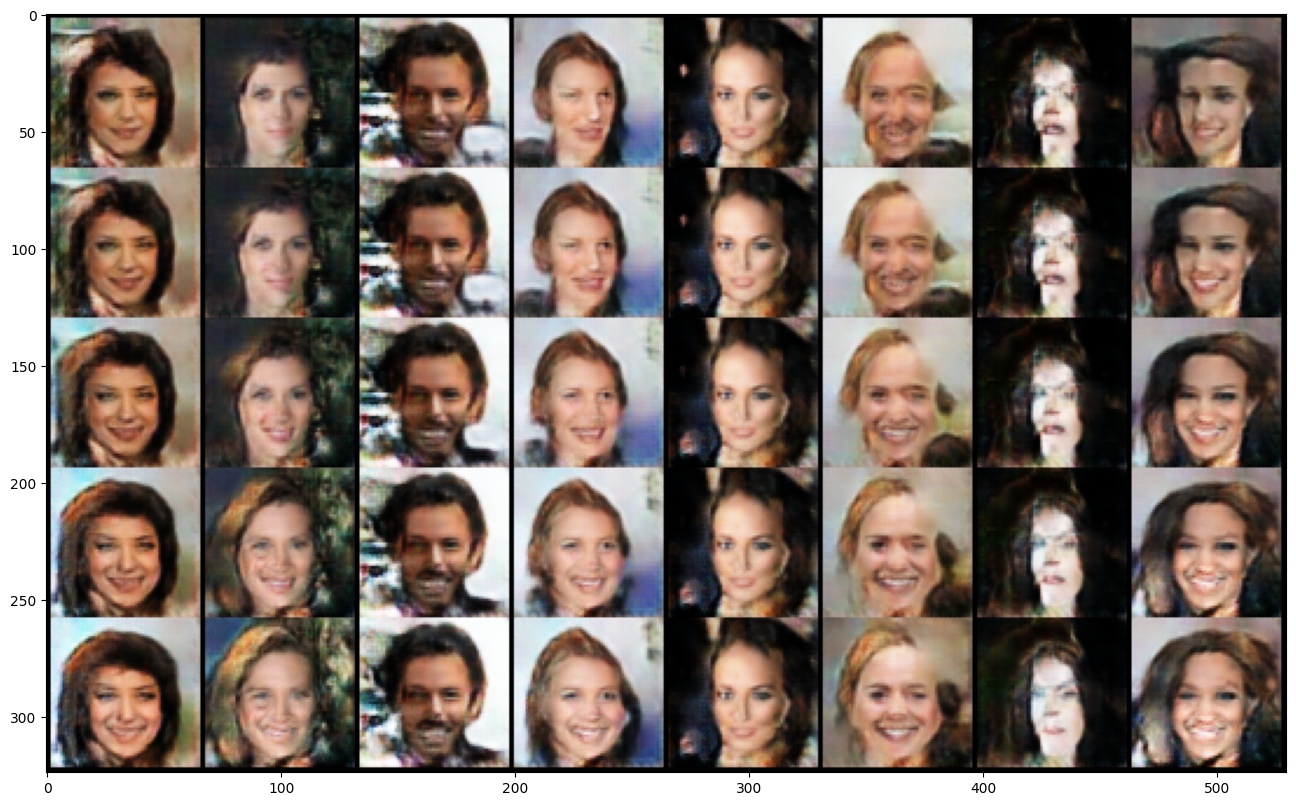

In [39]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

### Change me! ###
target_indices = feature_names.index("Smiling") # Feel free to change this value to any string from feature_names!

noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

## Entanglement and Regularization

In [40]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_score
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    '''
    Function to return the score of the current classifications, penalizing changes
    to other classes with an L2 norm.
    Parameters:
        current_classifications: the classifications associated with the current noise
        original_classifications: the classifications associated with the original noise
        target_indices: the index of the target class
        other_indices: the indices of the other classes
        penalty_weight: the amount that the penalty should be weighted in the overall score
    '''
    # Steps: 1) Calculate the change between the original and current classifications (as a tensor)
    #           by indexing into the other_indices you're trying to preserve, like in x[:, features].
    #        2) Calculate the norm (magnitude) of changes per example.
    #        3) Multiply the mean of the example norms by the penalty weight. 
    #           This will be your other_class_penalty.
    #           Make sure to negate the value since it's a penalty!
    #        4) Take the mean of the current classifications for the target feature over all the examples.
    #           This mean will be your target_score.
    #### START CODE HERE ####
    other_distances = current_classifications[:,other_indices] - original_classifications[:,other_indices]
    # Calculate the norm (magnitude) of changes per example and multiply by penalty weight
    other_class_penalty = -torch.norm(other_distances, dim=1).mean() * penalty_weight
    # Take the mean of the current classifications for the target feature
    target_score = current_classifications[:, target_indices].mean()
    #### END CODE HERE ####
    return target_score + other_class_penalty

In [41]:
# UNIT TEST
assert torch.isclose(
    get_score(torch.ones(4, 3), torch.zeros(4, 3), [0], [1, 2], 0.2), 
    1 - torch.sqrt(torch.tensor(2.)) * 0.2
)
rows = 10
current_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()
original_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()

# Must be 3
assert get_score(current_class, original_class, [1, 3] , [0, 2], 0.2).item() == 3

current_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()
original_class = torch.tensor([[4] * rows, [4] * rows, [2] * rows, [1] * rows]).T.float()

# Must be 3 - 0.2 * sqrt(10)
assert torch.isclose(get_score(current_class, original_class, [1, 3] , [0, 2], 0.2), 
                     -torch.sqrt(torch.tensor(10.0)) * 0.2 + 3)

print("Success!")

Success!


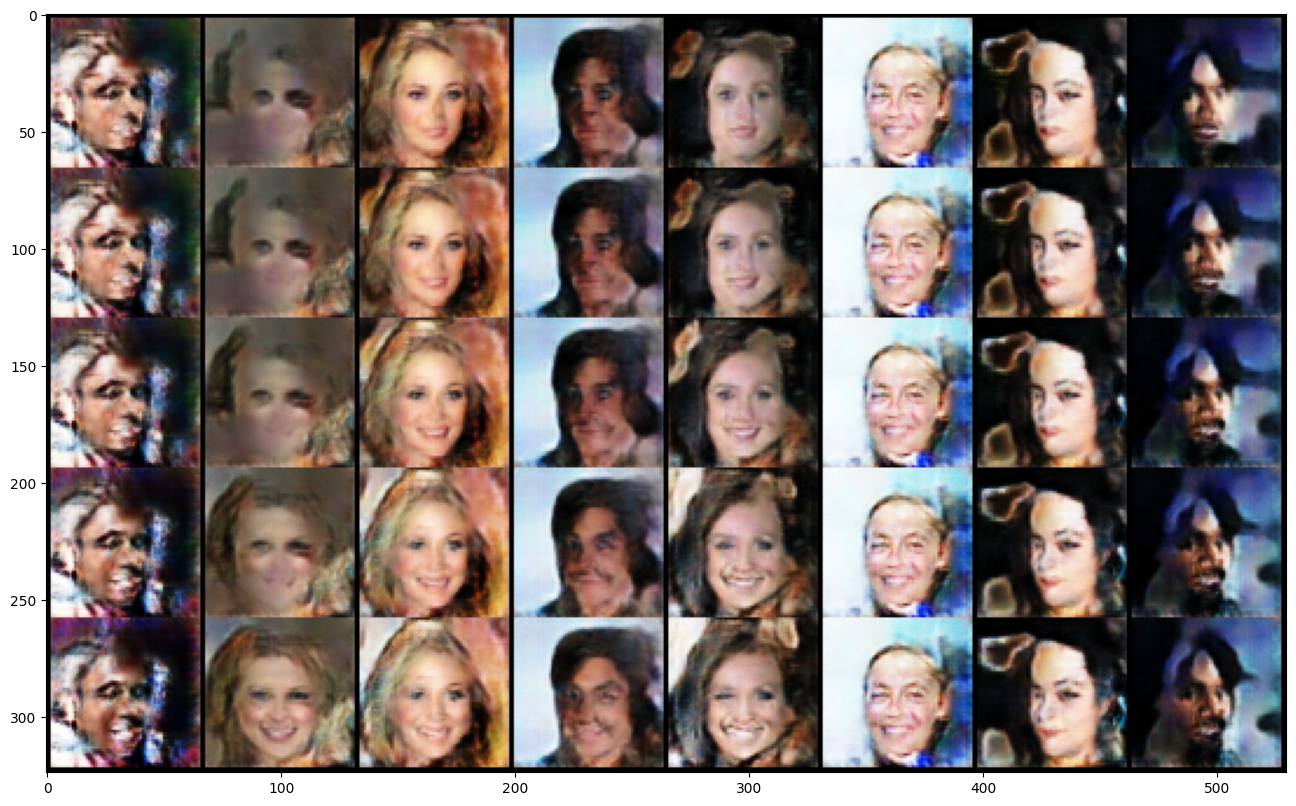

In [42]:
fake_image_history = []
### Change me! ###
target_indices = feature_names.index("Smiling") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)